In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

from __future__ import print_function, division
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from keras.models import model_from_json
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from matplotlib import pyplot
import pandas as pd
import numpy as np
import os


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Using TensorFlow backend.


In [ ]:
def importData(chanel,directory='/content/drive/My Drive/Colab Notebooks/100RH/Data.csv'):
    df=pd.DataFrame()
    df=pd.read_csv(directory)

    Labels= df.groupby(['Label'])
    CRH=Labels.get_group('CRH')
    ORH=Labels.get_group('ORH')
    N=  Labels.get_group('N')

    ORH_Data=ORH.groupby(['nSample'])
    CRH_Data=CRH.groupby(['nSample'])
    N_Data=N.groupby(['nSample'])
    data=[]
    labels=[]

    for i in range(1,1201):
        ORH=ORH_Data.get_group(i)#.iloc[:,2:]
        CRH=CRH_Data.get_group(i)#.iloc[:,2:]
        data.append(ORH[chanel])
        labels.append(0)
        data.append(CRH[chanel])
        labels.append(1)
    for i in range(1,801):
        N=N_Data.get_group(i)
        data.append(N[chanel])
        labels.append(2)

    data=normalize(data, axis = 1)

    xTrain,xTest,yTrain,yTest= train_test_split(data,labels, test_size=0.2, random_state=42)
    xTrain=np.array(xTrain)
    xTest=np.array(xTest)
    yTrain=np.array(yTrain)
    yTest=np.array(yTest)
    print('Data loaded')

    return xTrain,xTest,yTrain,yTest

def saveData(self,folderName='/content/drive/My Drive/Colab Notebooks/100RH/'):
    df.to_csv(folderName+'fileData.csv',index=False)
    print('Data saved')

def saveModel(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to disk")

def loadModel():
    #Save and reuse model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model

    loaded_model.load_weights("model.h5")

    print("Loaded model from disk")
    return loaded_model

In [ ]:
xTrain,xTest,yTrain,yTest=importData(chanel=" T7")

xTrain=xTrain.reshape(2560,225,1)
yTrain=yTrain.reshape(2560,1)
xTest=xTest.reshape(640,225,1)
yTest=yTest.reshape(640,1)
yyTest=np.zeros((640,3))
yyTrain=np.zeros((2560,3))

for j in range(0,640):
    yyTest[j][yTest[j]]=1
for j in range(0,2560):
    yyTrain[j][yTrain[j]]=1

Data loaded


In [ ]:
def getModel(window_size=225, filtersLength=40, nb_input_series=1, nb_outputs=3, filters=20):
    model = Sequential((
        #Convolution1D(filters=filters, filter_length=filtersLength, activation='relu', input_shape=(window_size, nb_input_series)),
        Convolution1D(nb_filter=filters, filter_length=filtersLength, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(),\
        Convolution1D(nb_filter=filters, filter_length=filtersLength, activation='relu'),
        MaxPooling1D(),\
        #Convolution1D(nb_filter=filters, filter_length=filtersLength, activation='relu'),
        #MaxPooling1D(),\
        Flatten(),
        #Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
        #Dense(nb_outputs, activation='sigmoid'),
        Dense(nb_outputs, activation='softmax'),
    ))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

In [ ]:
nb_series=1
nb_outputs=3
filtersLength=40
window_size=225
filters =50
epochs=50
batchSize=20

In [ ]:
model=getModel(window_size=window_size, filtersLength=filtersLength, nb_input_series=nb_series, nb_outputs=nb_outputs,filters=filters)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, filters, filtersLength))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history=model.fit(xTrain, yyTrain, nb_epoch=epochs, batch_size=batchSize, validation_data=(xTest, yyTest))

saveModel(model)
# evaluate loaded

score =model.evaluate(xTest, yyTest, batch_size=batchSize,verbose=0)

print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))



pred = model.predict(xTest)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(225, 1), filters=50, kernel_size=40)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=50, kernel_size=40)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  




Model with input size (None, 225, 1), output size (None, 3), 50 conv filters of length 40
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 186, 50)           2050      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 54, 50)            100050    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1350)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4053      
Total params: 106,153
Traina

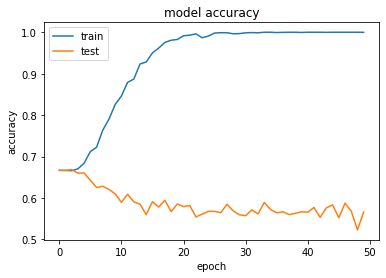

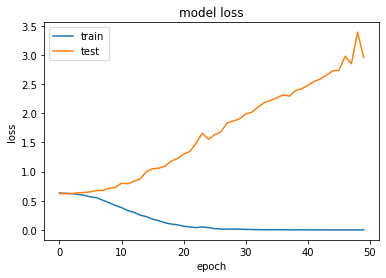

In [ ]:
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()